# Variational Autoencoders (VAEs)

## What are VAEs?

Variational Autoencoders (VAEs) are a probabilistic extension of autoencoders that learn a continuous latent representation of data. Unlike standard autoencoders, VAEs:

1. **Learn a distribution** over the latent space (not just a point estimate)
2. **Can generate new samples** by sampling from the latent distribution
3. **Have a probabilistic foundation** based on variational inference

### Key Concepts:

1. **Encoder**: Maps input to parameters of a latent distribution (usually Gaussian)
2. **Reparameterization Trick**: Allows backpropagation through stochastic sampling
3. **Decoder**: Maps samples from latent space back to data space
4. **ELBO**: Evidence Lower Bound - the objective function combining reconstruction and KL divergence

### Mathematical Foundation:

VAEs maximize the Evidence Lower Bound (ELBO):
$$\mathcal{L}(\theta, \phi; x) = \mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)] - D_{KL}(q_\phi(z|x) || p(z))$$

Where:
- First term: Reconstruction loss
- Second term: KL divergence (regularization)

In this tutorial, we'll implement VAEs and explore their capabilities using MNIST.

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## Loading and Preprocessing Data

Training samples: 60000
Test samples: 10000


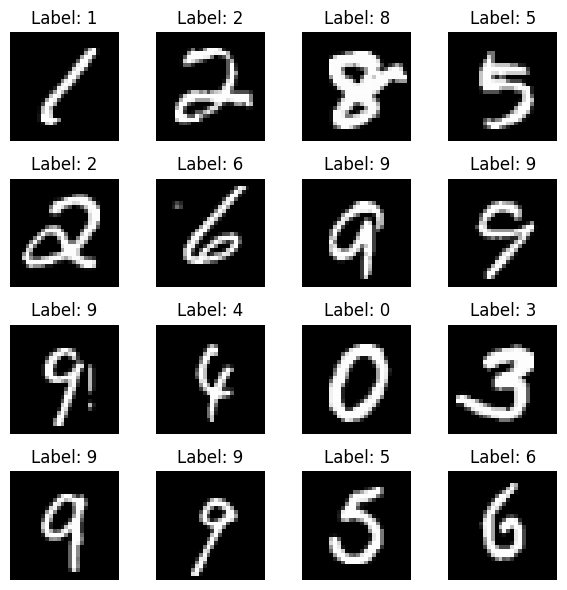

In [2]:
# Data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                          download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                         download=True, transform=transform)

# Create data loaders
batch_size = 128
# Set num_workers=0 for compatibility across platforms
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f'Training samples: {len(train_dataset)}')
print(f'Test samples: {len(test_dataset)}')

# Visualize some samples
def show_batch(loader, n=16):
    data, labels = next(iter(loader))
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    for i, ax in enumerate(axes.flat):
        if i < n:
            ax.imshow(data[i].squeeze(), cmap='gray')
            ax.set_title(f'Label: {labels[i]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

show_batch(train_loader)

## Building a Basic VAE

Let's implement a VAE with the key components:
1. Encoder that outputs mean and log-variance
2. Reparameterization trick for sampling
3. Decoder that reconstructs from latent samples

In [3]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)  # Mean
        self.fc22 = nn.Linear(hidden_dim, latent_dim)  # Log variance
        
        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)
        
    def encode(self, x):
        """Encode input to latent distribution parameters"""
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)  # mu, log_var
    
    def reparameterize(self, mu, log_var):
        """Reparameterization trick: z = mu + eps * std"""
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        """Decode from latent space to reconstruction"""
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))
    
    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

# Create model instance
vae = VAE(latent_dim=20).to(device)
print(f'Model parameters: {sum(p.numel() for p in vae.parameters()):,}')

Model parameters: 652,824


## Understanding the VAE Loss Function

The VAE loss has two components:
1. **Reconstruction Loss**: How well the decoder reconstructs the input
2. **KL Divergence**: How close the learned distribution is to the prior (standard Gaussian)

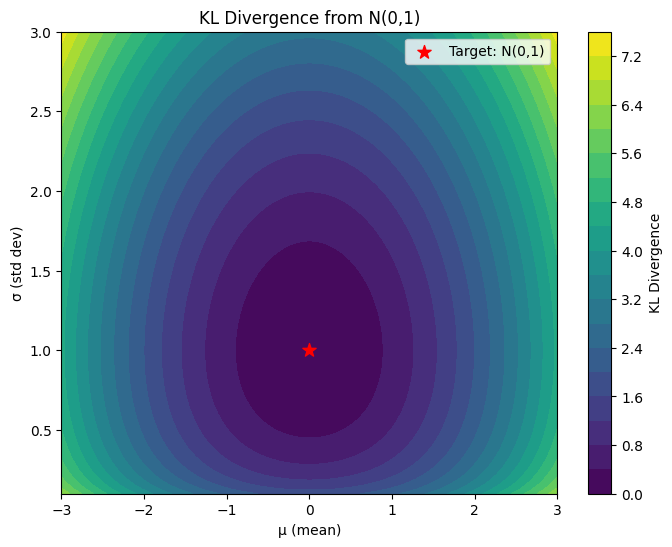

In [4]:
def vae_loss(recon_x, x, mu, log_var, beta=1.0):
    """
    VAE loss = Reconstruction loss + KL divergence
    
    Args:
        recon_x: reconstructed input
        x: original input
        mu: latent mean
        log_var: latent log variance
        beta: weight for KL term (beta-VAE)
    """
    # Reconstruction loss (binary cross entropy)
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    
    # KL divergence: -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return BCE + beta * KLD, BCE, KLD

# Visualize the components of the loss
def plot_loss_landscape():
    """Visualize how KL divergence changes with mu and sigma"""
    mu_range = np.linspace(-3, 3, 100)
    sigma_range = np.linspace(0.1, 3, 100)
    
    KL = np.zeros((len(sigma_range), len(mu_range)))
    
    for i, sigma in enumerate(sigma_range):
        for j, mu in enumerate(mu_range):
            # KL divergence for single dimension
            KL[i, j] = 0.5 * (sigma**2 + mu**2 - 1 - np.log(sigma**2))
    
    plt.figure(figsize=(8, 6))
    plt.contourf(mu_range, sigma_range, KL, levels=20, cmap='viridis')
    plt.colorbar(label='KL Divergence')
    plt.xlabel('μ (mean)')
    plt.ylabel('σ (std dev)')
    plt.title('KL Divergence from N(0,1)')
    plt.scatter([0], [1], color='red', s=100, marker='*', label='Target: N(0,1)')
    plt.legend()
    plt.show()

plot_loss_landscape()

## Training the VAE

In [5]:
def train_vae(model, train_loader, test_loader, epochs=10, lr=1e-3, beta=1.0):
    """Train the VAE model"""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        train_bce = 0
        train_kld = 0
        
        for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')):
            data = data.to(device)
            optimizer.zero_grad()
            
            recon_batch, mu, log_var = model(data)
            loss, bce, kld = vae_loss(recon_batch, data, mu, log_var, beta)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_bce += bce.item()
            train_kld += kld.item()
        
        # Evaluation
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data, _ in test_loader:
                data = data.to(device)
                recon_batch, mu, log_var = model(data)
                loss, _, _ = vae_loss(recon_batch, data, mu, log_var, beta)
                test_loss += loss.item()
        
        # Average losses
        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_test_loss = test_loss / len(test_loader.dataset)
        avg_bce = train_bce / len(train_loader.dataset)
        avg_kld = train_kld / len(train_loader.dataset)
        
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        
        print(f'Train Loss: {avg_train_loss:.4f} (BCE: {avg_bce:.4f}, KLD: {avg_kld:.4f}), '
              f'Test Loss: {avg_test_loss:.4f}')
    
    return train_losses, test_losses

# Train the model
print("Training VAE...")
train_losses, test_losses = train_vae(vae, train_loader, test_loader, epochs=10)

Training VAE...


Epoch 1/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:01<00:00, 234.54it/s]


Train Loss: 164.4519 (BCE: 148.6782, KLD: 15.7737), Test Loss: 126.8860


Epoch 2/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:02<00:00, 222.19it/s]


Train Loss: 120.9540 (BCE: 98.3215, KLD: 22.6325), Test Loss: 115.5621


Epoch 3/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:02<00:00, 220.54it/s]


Train Loss: 114.4320 (BCE: 90.3546, KLD: 24.0774), Test Loss: 112.1357


Epoch 4/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:01<00:00, 234.99it/s]


Train Loss: 111.5508 (BCE: 86.9824, KLD: 24.5684), Test Loss: 109.8804


Epoch 5/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:01<00:00, 241.22it/s]


Train Loss: 109.8581 (BCE: 84.9919, KLD: 24.8662), Test Loss: 108.6499


Epoch 6/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:02<00:00, 202.40it/s]


Train Loss: 108.6987 (BCE: 83.6852, KLD: 25.0135), Test Loss: 107.5492


Epoch 7/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:02<00:00, 185.28it/s]


Train Loss: 107.8319 (BCE: 82.6750, KLD: 25.1568), Test Loss: 106.9096


Epoch 8/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:02<00:00, 219.30it/s]


Train Loss: 107.1670 (BCE: 81.9248, KLD: 25.2422), Test Loss: 106.3797


Epoch 9/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:02<00:00, 214.81it/s]


Train Loss: 106.6615 (BCE: 81.3683, KLD: 25.2932), Test Loss: 106.0086


Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:02<00:00, 223.66it/s]


Train Loss: 106.2783 (BCE: 80.8945, KLD: 25.3838), Test Loss: 105.5473


## Visualizing Reconstructions and Samples

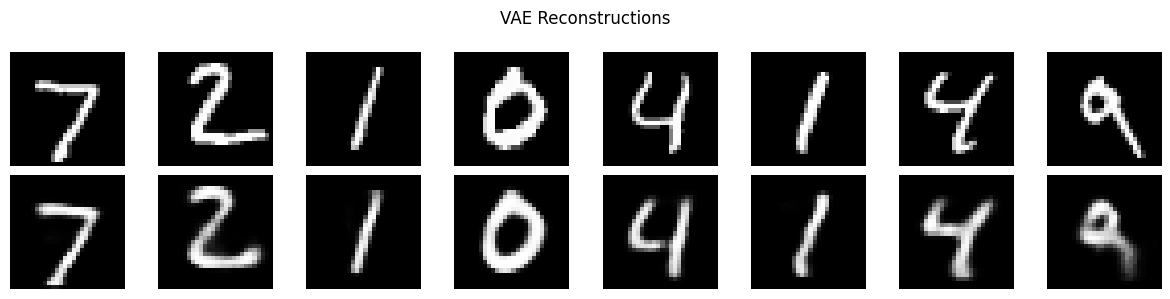

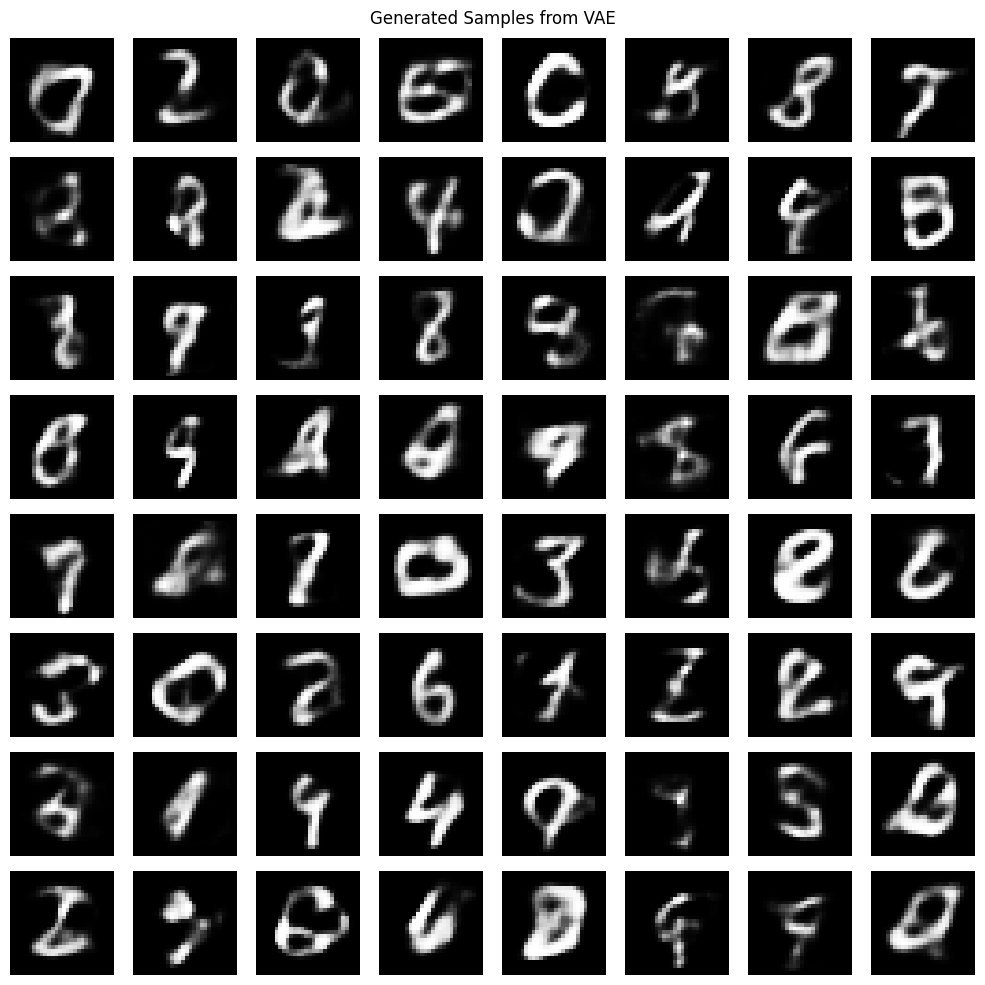

In [6]:
def visualize_reconstructions(model, test_loader, n=8):
    """Compare original images with VAE reconstructions"""
    model.eval()
    
    data, _ = next(iter(test_loader))
    data = data[:n].to(device)
    
    with torch.no_grad():
        recon, _, _ = model(data)
    
    # Plot
    fig, axes = plt.subplots(2, n, figsize=(n*1.5, 3))
    
    for i in range(n):
        # Original
        axes[0, i].imshow(data[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_ylabel('Original', rotation=90)
        
        # Reconstruction
        axes[1, i].imshow(recon[i].cpu().view(28, 28), cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_ylabel('Reconstructed', rotation=90)
    
    plt.suptitle('VAE Reconstructions')
    plt.tight_layout()
    plt.show()

def generate_samples(model, n_samples=64, latent_dim=20):
    """Generate new samples from the latent space"""
    model.eval()
    
    with torch.no_grad():
        # Sample from standard normal
        z = torch.randn(n_samples, latent_dim).to(device)
        samples = model.decode(z)
    
    # Plot generated samples
    n_cols = int(np.sqrt(n_samples))
    fig, axes = plt.subplots(n_cols, n_cols, figsize=(10, 10))
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(samples[i].cpu().view(28, 28), cmap='gray')
        ax.axis('off')
    
    plt.suptitle('Generated Samples from VAE')
    plt.tight_layout()
    plt.show()

# Visualize results
visualize_reconstructions(vae, test_loader)
generate_samples(vae)

## Exploring the Latent Space

One of the key properties of VAEs is that they learn a structured latent space

Explained variance ratio: [0.08852495 0.08503826]


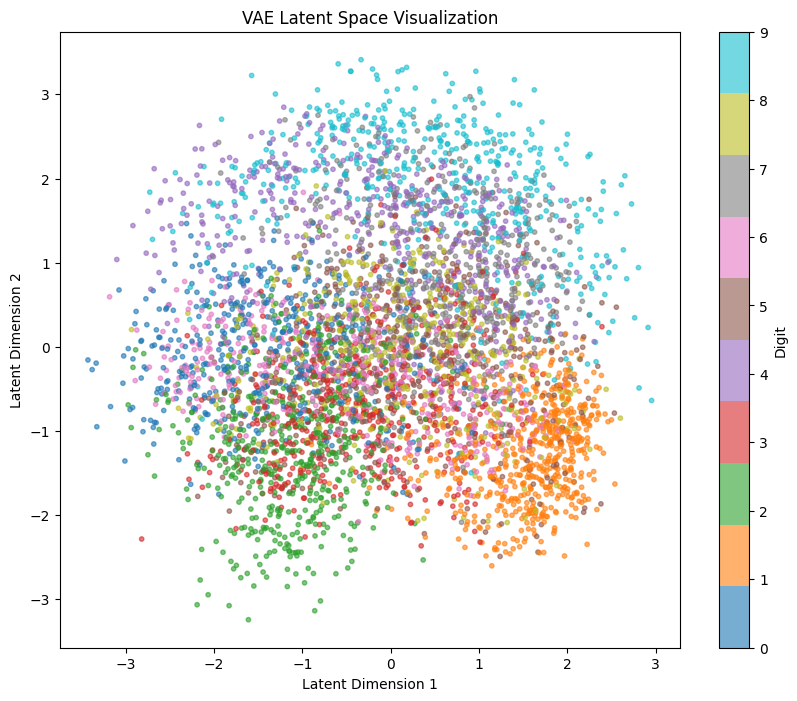

In [7]:
def visualize_latent_space(model, test_loader, n_samples=5000):
    """Visualize the 2D latent space (works best when latent_dim=2)"""
    model.eval()
    
    latents = []
    labels = []
    
    with torch.no_grad():
        for i, (data, label) in enumerate(test_loader):
            if i * batch_size > n_samples:
                break
            data = data.to(device)
            mu, _ = model.encode(data.view(-1, 784))
            latents.append(mu.cpu())
            labels.append(label)
    
    latents = torch.cat(latents, 0).numpy()
    labels = torch.cat(labels, 0).numpy()
    
    # If latent space is not 2D, use PCA
    if latents.shape[1] > 2:
        from sklearn.decomposition import PCA
        pca = PCA(n_components=2)
        latents_2d = pca.fit_transform(latents)
        print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    else:
        latents_2d = latents
    
    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], 
                         c=labels, cmap='tab10', alpha=0.6, s=10)
    plt.colorbar(scatter, label='Digit')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('VAE Latent Space Visualization')
    plt.show()

# Visualize latent space
visualize_latent_space(vae, test_loader)

## Latent Space Interpolation

VAEs allow smooth interpolation between different data points

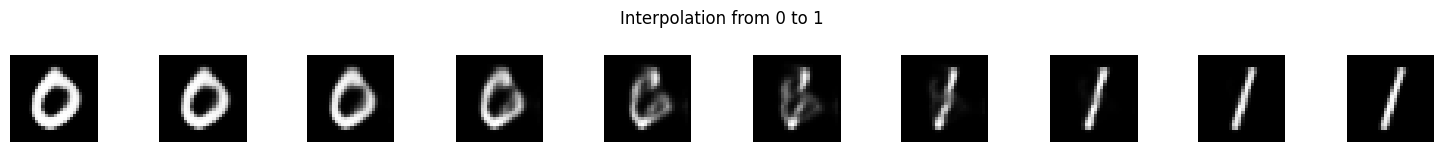

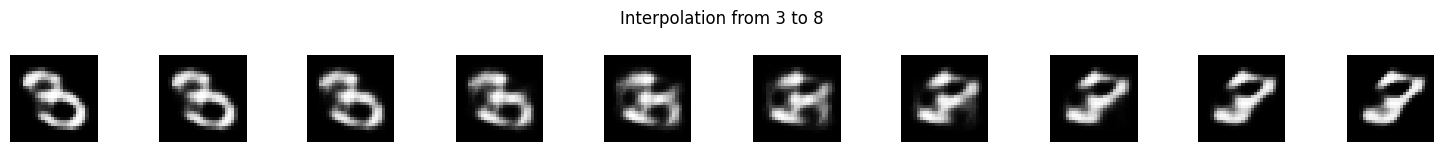

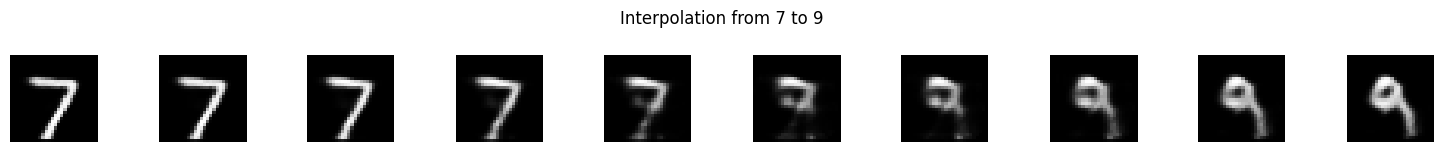

In [8]:
def interpolate_digits(model, digit1, digit2, n_steps=10):
    """Interpolate between two digits in latent space"""
    model.eval()
    
    # Find examples of each digit
    img1, img2 = None, None
    for data, labels in test_loader:
        if img1 is None:
            idx1 = (labels == digit1).nonzero(as_tuple=True)[0]
            if len(idx1) > 0:
                img1 = data[idx1[0]].unsqueeze(0).to(device)
        if img2 is None:
            idx2 = (labels == digit2).nonzero(as_tuple=True)[0]
            if len(idx2) > 0:
                img2 = data[idx2[0]].unsqueeze(0).to(device)
        if img1 is not None and img2 is not None:
            break
    
    with torch.no_grad():
        # Encode to latent space
        mu1, _ = model.encode(img1.view(-1, 784))
        mu2, _ = model.encode(img2.view(-1, 784))
        
        # Interpolate
        interpolations = []
        for alpha in np.linspace(0, 1, n_steps):
            z = (1 - alpha) * mu1 + alpha * mu2
            interpolations.append(model.decode(z))
    
    # Plot
    fig, axes = plt.subplots(1, n_steps, figsize=(n_steps*1.5, 1.5))
    for i, ax in enumerate(axes):
        ax.imshow(interpolations[i].cpu().view(28, 28), cmap='gray')
        ax.axis('off')
    
    plt.suptitle(f'Interpolation from {digit1} to {digit2}')
    plt.tight_layout()
    plt.show()

# Interpolate between different digit pairs
interpolate_digits(vae, 0, 1)
interpolate_digits(vae, 3, 8)
interpolate_digits(vae, 7, 9)

## Convolutional VAE

For better performance on images, let's implement a convolutional VAE

In [9]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(ConvVAE, self).__init__()
        
        # Encoder
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        
        # Flatten size: 128 * 4 * 4 = 2048
        self.fc_mu = nn.Linear(2048, latent_dim)
        self.fc_log_var = nn.Linear(2048, latent_dim)
        
        # Decoder
        self.fc_decode = nn.Linear(latent_dim, 2048)
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        
    def encode(self, x):
        # Convolutional layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Get distribution parameters
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        # Fully connected
        x = self.fc_decode(z)
        x = x.view(x.size(0), 128, 4, 4)
        
        # Deconvolutional layers
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = torch.sigmoid(self.deconv3(x))
        
        return x
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        recon = self.decode(z)
        return recon, mu, log_var

# Create and train ConvVAE
conv_vae = ConvVAE(latent_dim=20).to(device)
print(f'ConvVAE parameters: {sum(p.numel() for p in conv_vae.parameters()):,}')

ConvVAE parameters: 310,185


In [12]:
# Alternative: Pad the input to 32x32 instead of resizing output
def pad_to_32x32(x):
    """Pad 28x28 images to 32x32"""
    return F.pad(x, (2, 2, 2, 2), mode='constant', value=0)

# Modified training loop using padding approach
def train_with_padding():
    print("Training ConvVAE with input padding...")
    optimizer = optim.Adam(conv_vae.parameters(), lr=1e-3)
    conv_vae.train()
    
    for epoch in range(5):
        train_loss = 0
        for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/5')):
            # Pad input to 32x32
            data = pad_to_32x32(data).to(device)
            optimizer.zero_grad()
            
            recon_batch, mu, log_var = conv_vae(data)
            loss = conv_vae_loss(recon_batch, data, mu, log_var)
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        avg_loss = train_loss / len(train_loader.dataset)
        print(f'Average loss: {avg_loss:.4f}')

train_with_padding()

Input size: torch.Size([1, 1, 28, 28])
Output size: torch.Size([1, 1, 32, 32])
Mu size: torch.Size([1, 20])
Log_var size: torch.Size([1, 20])
Training ConvVAE with input padding...


Epoch 1/5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:24<00:00, 19.08it/s]


Average loss: 183.0804


Epoch 2/5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:25<00:00, 18.09it/s]


Average loss: 114.6966


Epoch 3/5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:24<00:00, 18.82it/s]


Average loss: 108.4883


Epoch 4/5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:25<00:00, 18.72it/s]


Average loss: 105.9355


Epoch 5/5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:25<00:00, 18.18it/s]

Average loss: 104.6155


## Conditional VAE (CVAE)

Conditional VAEs allow us to control the generation process by conditioning on labels

In [29]:
class CVAE(nn.Module):
    def __init__(self, input_dim=784, label_dim=10, hidden_dim=400, latent_dim=20):
        super(CVAE, self).__init__()
        
        # Encoder
        self.fc1 = nn.Linear(input_dim + label_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)  # Mean
        self.fc22 = nn.Linear(hidden_dim, latent_dim)  # Log variance
        
        # Decoder
        self.fc3 = nn.Linear(latent_dim + label_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)
        
    def encode(self, x, c):
        """Encode input and condition to latent distribution"""
        inputs = torch.cat([x, c], dim=1)
        h1 = F.relu(self.fc1(inputs))
        return self.fc21(h1), self.fc22(h1)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, c):
        """Decode from latent space and condition"""
        inputs = torch.cat([z, c], dim=1)
        h3 = F.relu(self.fc3(inputs))
        return torch.sigmoid(self.fc4(h3))
    
    def forward(self, x, c):
        mu, log_var = self.encode(x.view(-1, 784), c)
        z = self.reparameterize(mu, log_var)
        return self.decode(z, c), mu, log_var

# Create CVAE
cvae = CVAE(latent_dim=20).to(device)

def train_cvae_epoch(model, train_loader, optimizer):
    """Train CVAE for one epoch"""
    model.train()
    train_loss = 0
    
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)
        
        # One-hot encode labels
        c = F.one_hot(labels, num_classes=10).float()
        
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data, c)
        loss, _, _ = vae_loss(recon_batch, data, mu, log_var)
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    return train_loss / len(train_loader.dataset)

# Train CVAE
print("Training Conditional VAE...")
cvae_optimizer = optim.Adam(cvae.parameters(), lr=1e-3)
for epoch in range(20):
    avg_loss = train_cvae_epoch(cvae, train_loader, cvae_optimizer)
    print(f'Epoch {epoch+1}/20, Loss: {avg_loss:.4f}')

Training Conditional VAE...
Epoch 1/5, Loss: 163.6776
Epoch 2/5, Loss: 119.4999
Epoch 3/5, Loss: 112.1359
Epoch 4/5, Loss: 108.8680
Epoch 5/5, Loss: 106.8586
Epoch 6/5, Loss: 105.5027
Epoch 7/5, Loss: 104.4351
Epoch 8/5, Loss: 103.6167
Epoch 9/5, Loss: 102.9994
Epoch 10/5, Loss: 102.4601
Epoch 11/5, Loss: 101.9919
Epoch 12/5, Loss: 101.5667
Epoch 13/5, Loss: 101.2214
Epoch 14/5, Loss: 100.9566
Epoch 15/5, Loss: 100.6263
Epoch 16/5, Loss: 100.3991
Epoch 17/5, Loss: 100.1627
Epoch 18/5, Loss: 99.9694
Epoch 19/5, Loss: 99.7710
Epoch 20/5, Loss: 99.6060


## Generating Specific Digits with CVAE

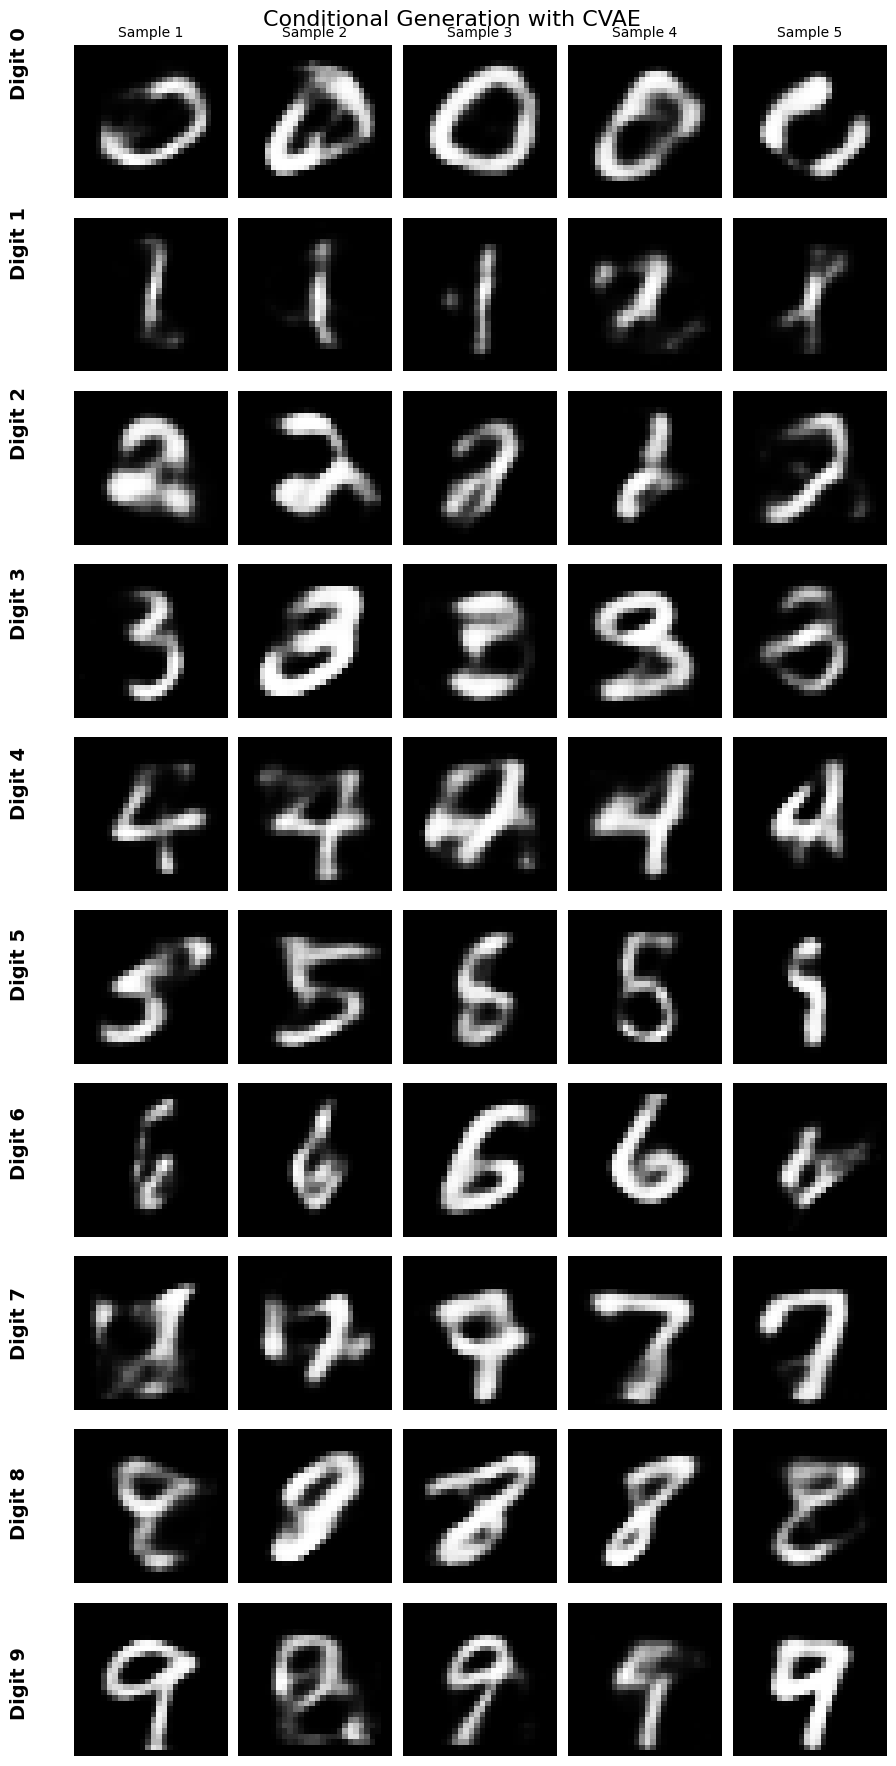

In [30]:
def generate_specific_digits(model, digits, n_samples=5):
    """Generate specific digits using CVAE"""
    model.eval()
    
    fig, axes = plt.subplots(len(digits), n_samples, figsize=(n_samples*1.8, len(digits)*1.8))
    
    # Handle single row case
    if len(digits) == 1:
        axes = axes.reshape(1, -1)
    
    with torch.no_grad():
        for i, digit in enumerate(digits):
            # Create condition
            c = torch.zeros(n_samples, 10).to(device)
            c[:, digit] = 1
            
            # Sample from latent space
            z = torch.randn(n_samples, 20).to(device)
            
            # Generate
            samples = model.decode(z, c)
            
            # Plot samples
            for j in range(n_samples):
                ax = axes[i, j]
                ax.imshow(samples[j].cpu().view(28, 28), cmap='gray')
                ax.axis('off')
                
                # Add sample number as column title (only for first row)
                if i == 0:
                    ax.set_title(f'Sample {j+1}', fontsize=10)
            
            # Add digit label as row title
            fig.text(0.02, 1 - (i + 0.5) / len(digits), f'Digit {digit}', 
                    rotation=90, verticalalignment='center', 
                    horizontalalignment='center', fontsize=14, fontweight='bold')
    
    plt.suptitle('Conditional Generation with CVAE', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(left=0.08)  # Make room for labels
    plt.show()

# Generate specific digits
generate_specific_digits(cvae, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], n_samples=5)

## β-VAE: Disentangled Representations

β-VAE uses a higher weight on the KL term to encourage more disentangled representations


Training with β=0.1...
Epoch 1, Loss: 143.5570
Epoch 2, Loss: 104.4046
Epoch 3, Loss: 99.1745
Epoch 4, Loss: 96.3270
Epoch 5, Loss: 94.4662
Epoch 6, Loss: 93.0596
Epoch 7, Loss: 92.0084
Epoch 8, Loss: 91.1591
Epoch 9, Loss: 90.3988
Epoch 10, Loss: 89.7984

Training with β=1.0...
Epoch 1, Loss: 162.1125
Epoch 2, Loss: 125.0062
Epoch 3, Loss: 119.8201
Epoch 4, Loss: 117.1579
Epoch 5, Loss: 115.3746
Epoch 6, Loss: 114.1034
Epoch 7, Loss: 113.1649
Epoch 8, Loss: 112.4121
Epoch 9, Loss: 111.7369
Epoch 10, Loss: 111.1601

Training with β=4.0...
Epoch 1, Loss: 189.0623
Epoch 2, Loss: 160.9151
Epoch 3, Loss: 156.6173
Epoch 4, Loss: 154.5913
Epoch 5, Loss: 153.3085
Epoch 6, Loss: 152.2679
Epoch 7, Loss: 151.6313
Epoch 8, Loss: 151.0397
Epoch 9, Loss: 150.4847
Epoch 10, Loss: 150.0428

Training with β=10.0...
Epoch 1, Loss: 209.5555
Epoch 2, Loss: 191.9668
Epoch 3, Loss: 188.9940
Epoch 4, Loss: 187.6423
Epoch 5, Loss: 186.8158
Epoch 6, Loss: 186.3170
Epoch 7, Loss: 185.8323
Epoch 8, Loss: 185.3

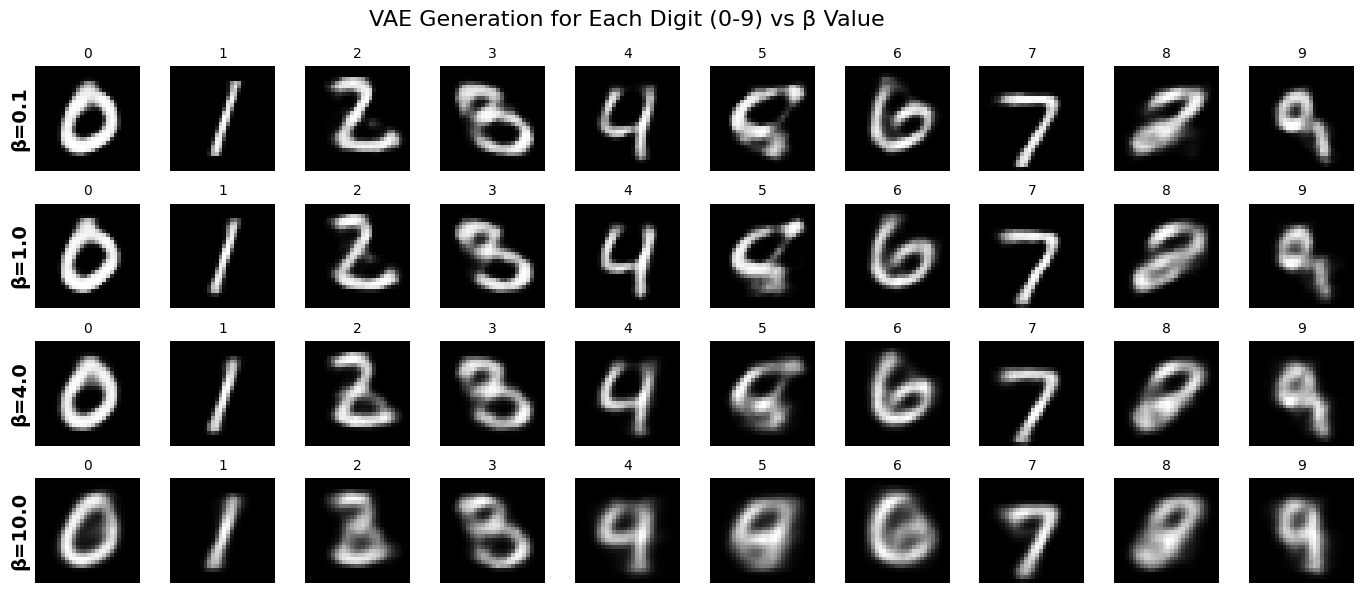

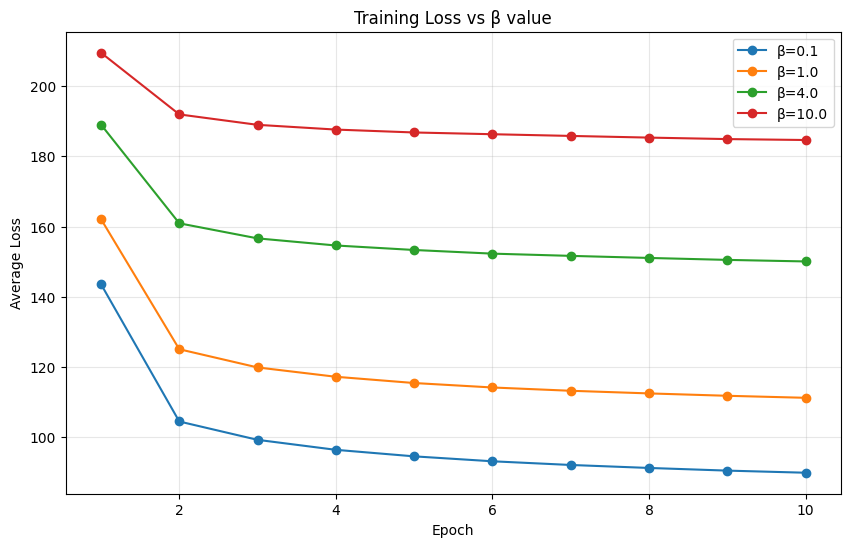

In [26]:
def compare_beta_values_all_digits(beta_values=[0.1, 1.0, 4.0, 10.0]):
    """Train VAEs with different beta values and compare - showing all 10 digits"""
    results = {}
    
    for beta in beta_values:
        print(f"\nTraining with β={beta}...")
        model = VAE(latent_dim=10).to(device)
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        
        # Train for a few epochs
        losses = []
        for epoch in range(10):
            model.train()
            epoch_loss = 0
            for data, _ in train_loader:
                data = data.to(device)
                optimizer.zero_grad()
                
                recon, mu, log_var = model(data)
                loss_output = vae_loss(recon, data, mu, log_var, beta=beta)
                
                # Handle case where vae_loss returns tuple
                if isinstance(loss_output, tuple):
                    loss = loss_output[0]
                else:
                    loss = loss_output
                
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            
            avg_loss = epoch_loss / len(train_loader.dataset)
            losses.append(avg_loss)
            print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
        
        results[beta] = (model, losses)
    
    # Visualize samples from each model - showing all 10 digits
    fig, axes = plt.subplots(len(beta_values), 10, figsize=(15, len(beta_values)*1.5))
    
    # Handle single row case
    if len(beta_values) == 1:
        axes = axes.reshape(1, -1)
    
    for i, (beta, (model, _)) in enumerate(results.items()):
        model.eval()
        with torch.no_grad():
            # Get one example of each digit (0-9) from test set
            digit_examples = {}
            for data, labels in test_loader:
                for j, label in enumerate(labels):
                    digit = label.item()
                    if digit not in digit_examples and len(digit_examples) < 10:
                        digit_examples[digit] = data[j:j+1]  # Keep batch dimension
                    if len(digit_examples) == 10:
                        break
                if len(digit_examples) == 10:
                    break
            
            # Encode each digit to get latent representation, then decode
            for digit in range(10):
                ax = axes[i, digit]
                
                if digit in digit_examples:
                    example = digit_examples[digit].to(device)
                    # Flatten the input for VAE (from [1, 1, 28, 28] to [1, 784])
                    example_flat = example.view(example.size(0), -1)
                    mu, log_var = model.encode(example_flat)
                    # Use mean (mu) for more stable results
                    z = mu
                    sample = model.decode(z)
                    generated_image = sample[0].cpu().view(28, 28)
                else:
                    # Fallback to random sample if digit not found
                    z = torch.randn(1, 10).to(device)
                    sample = model.decode(z)
                    generated_image = sample[0].cpu().view(28, 28)
                
                ax.imshow(generated_image, cmap='gray')
                ax.axis('off')
                ax.set_title(f'{digit}', fontsize=10)
            
            # Add row label on the left side
            axes[i, 0].text(-0.15, 0.5, f'β={beta}', transform=axes[i, 0].transAxes,
                           rotation=90, verticalalignment='center', 
                           horizontalalignment='center', fontsize=14, fontweight='bold')
    
    plt.suptitle('VAE Generation for Each Digit (0-9) vs β Value', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(left=0.1)
    plt.show()
    
    # Plot training loss curves
    plt.figure(figsize=(10, 6))
    for beta, (_, losses) in results.items():
        plt.plot(range(1, len(losses)+1), losses, marker='o', label=f'β={beta}')
    
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title('Training Loss vs β value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return results

# Compare different beta values showing all digits
beta_results = compare_beta_values_all_digits()

## Analyzing Latent Dimensions

Let's analyze what each latent dimension learns

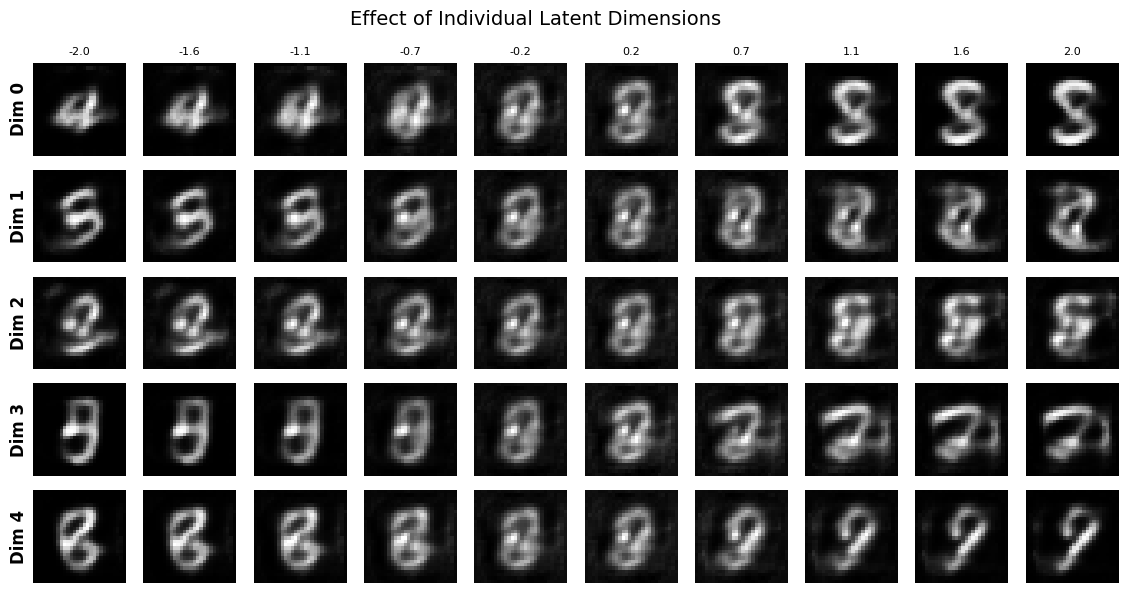

In [31]:
def analyze_latent_dimensions(model, n_dims=5, n_samples=10):
    """Analyze the effect of each latent dimension"""
    model.eval()
    
    # Sample a base latent vector
    z_base = torch.zeros(1, 20).to(device)
    
    fig, axes = plt.subplots(n_dims, n_samples, figsize=(n_samples*1.2, n_dims*1.2))
    
    # Handle single row case
    if n_dims == 1:
        axes = axes.reshape(1, -1)
    
    with torch.no_grad():
        for dim in range(n_dims):
            for i, val in enumerate(np.linspace(-2, 2, n_samples)):
                z = z_base.clone()
                z[0, dim] = val
                
                sample = model.decode(z)
                
                ax = axes[dim, i]
                ax.imshow(sample.cpu().view(28, 28), cmap='gray')
                ax.axis('off')
                
                # Add value as column title (only for first row)
                if dim == 0:
                    ax.set_title(f'{val:.1f}', fontsize=8)
            
            # Add dimension label as row title
            axes[dim, 0].text(-0.15, 0.5, f'Dim {dim}', transform=axes[dim, 0].transAxes,
                             rotation=90, verticalalignment='center', 
                             horizontalalignment='center', fontsize=12, fontweight='bold')
    
    plt.suptitle('Effect of Individual Latent Dimensions', fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(left=0.08)  # Make room for labels
    plt.show()

# Analyze latent dimensions
analyze_latent_dimensions(vae)

## Exercises

Now it's your turn to experiment with VAEs! Try these exercises:

### Exercise 1: Implement a VAE with Different Priors
Instead of using a standard Gaussian prior, try other distributions

In [17]:
# Exercise 1: VAE with different priors
class VAEWithCustomPrior(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20, prior='gaussian_mixture'):
        super(VAEWithCustomPrior, self).__init__()
        self.prior = prior
        # TODO: Implement encoder and decoder
        # TODO: Implement custom prior (e.g., Gaussian mixture, VampPrior)
        pass
    
    def kl_divergence_custom(self, mu, log_var):
        """
        Compute KL divergence with custom prior
        """
        # TODO: Implement KL divergence for your chosen prior
        pass

# Train and compare with standard VAE

### Exercise 2: Implement a Hierarchical VAE
Build a VAE with multiple layers of latent variables

In [ ]:
# Exercise 2: Hierarchical VAE
class HierarchicalVAE(nn.Module):
    def __init__(self, input_dim=784, latent_dims=[50, 20]):
        super(HierarchicalVAE, self).__init__()
        # TODO: Implement hierarchical latent structure
        # z2 ~ p(z2), z1 ~ p(z1|z2), x ~ p(x|z1)
        pass
    
    def forward(self, x):
        # TODO: Implement hierarchical encoding and decoding
        pass

# Implement and visualize the hierarchical structure

### Exercise 3: VAE for Anomaly Detection
Use VAE reconstruction error for detecting anomalies

In [ ]:
# Exercise 3: Anomaly Detection with VAE
def vae_anomaly_detection(model, normal_data, anomaly_data):
    """
    Use VAE for anomaly detection
    
    Args:
        model: trained VAE
        normal_data: data from normal distribution
        anomaly_data: potential anomalies
    """
    # TODO: Compute reconstruction errors
    # TODO: Set threshold based on normal data
    # TODO: Classify anomalies
    # TODO: Visualize results with ROC curve
    pass

# Test on MNIST vs Fashion-MNIST or corrupted images

### Exercise 4: Implement Info-VAE
Implement an Information-maximizing VAE that uses Maximum Mean Discrepancy

In [ ]:
# Exercise 4: Info-VAE
def compute_mmd(z, z_prior):
    """
    Compute Maximum Mean Discrepancy between z and prior
    """
    # TODO: Implement MMD with RBF kernel
    pass

class InfoVAE(VAE):
    def __init__(self, *args, alpha=1.0, lambda_mmd=1.0, **kwargs):
        super(InfoVAE, self).__init__(*args, **kwargs)
        self.alpha = alpha
        self.lambda_mmd = lambda_mmd
    
    def loss_function(self, recon_x, x, mu, log_var, z):
        # TODO: Implement Info-VAE loss
        # Loss = Recon + (1-alpha)*KL + (alpha+lambda-1)*MMD
        pass

# Compare with standard VAE

## Summary

In this tutorial, we've covered:

1. **VAE Theory**: Probabilistic framework and ELBO objective
2. **Implementation**: Basic VAE, ConvVAE, and Conditional VAE
3. **Key Concepts**: Reparameterization trick, KL divergence
4. **Applications**: Generation, interpolation, disentanglement
5. **Variants**: β-VAE for disentanglement, CVAE for conditional generation

Key takeaways:
- VAEs learn a probabilistic mapping to a latent space
- The ELBO balances reconstruction quality with latent space regularity
- Smooth latent space enables interpolation and meaningful generation
- Different variants (β-VAE, CVAE) offer different properties

VAEs are foundational for understanding modern generative models and provide a principled approach to unsupervised learning!